/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


Precisión del modelo Naive Bayes: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       267
           1       1.00      1.00      1.00       231
           2       1.00      1.00      1.00       268
           3       1.00      1.00      1.00       234

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



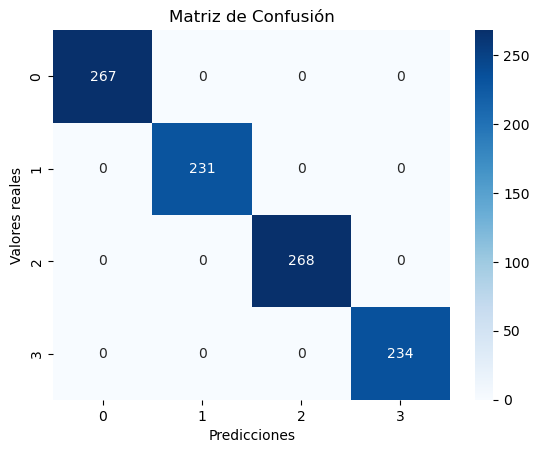

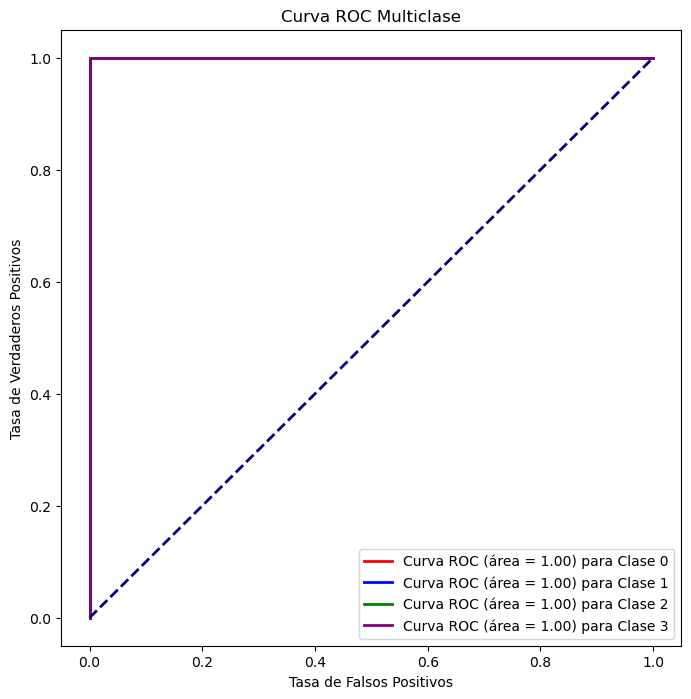

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def load_data(file_path):
    return pd.read_csv(file_path)  # Limitamos a 10000 registros

def preprocess_data(df):
    df.drop("Country", axis=1, inplace=True)
    
    df['Severity_None'].replace({1: 'None', 0: 'No'}, inplace=True)
    df['Severity_Mild'].replace({1: 'Mild', 0: 'No'}, inplace=True)
    df['Severity_Moderate'].replace({1: 'Moderate', 0: 'No'}, inplace=True)
    df['Severity_Severe'].replace({1: 'Severe', 0: 'No'}, inplace=True)
    
    def remove(lista):
        lista = set(lista)
        lista.discard("No")
        final = ''.join(lista)
        return final
    
    df['Condition'] = df['Severity_None'] + df['Severity_Mild'] + df['Severity_Moderate'] + df['Severity_Severe']
    df['Condition'] = df['Condition'].apply(remove)
    
    le = LabelEncoder()
    df['Condition'] = le.fit_transform(df['Condition'])
    
    return df

def encode_categorical_features(X_train, X_test):
    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)
    
    X_train.columns = X_train.columns.astype(str)
    X_test.columns = X_test.columns.astype(str)
    
    return X_train, X_test

def train_naive_bayes_model(X_train, y_train):
    nb_model = MultinomialNB()
    nb_model.fit(X_train, y_train)
    return nb_model

def evaluate_model(model, X_test, y_test):
    X_test_np = np.ascontiguousarray(X_test.to_numpy())
    y_pred = model.predict(X_test_np)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Precisión del modelo Naive Bayes: {accuracy:.2f}")
    
    report = classification_report(y_test, y_pred)
    print(report)
    
def plot_confusion_matrix(y_test, y_pred, labels):
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.show()

def plot_multiclass_roc_curve(y_test, y_probs, classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(8, 8))
    colors = ['red', 'blue', 'green', 'purple', 'orange']  # Puedes ajustar esto según el número de clases
    for i, color in zip(range(len(classes)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Curva ROC (área = {:.2f}) para Clase {}'.format(roc_auc[i], classes[i]))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC Multiclase')
    plt.legend(loc="lower right")
    plt.show()


# Cargar datos
df = load_data("Cleaned-Data.csv")
df = preprocess_data(df)

X = df.drop(['Condition'], axis=1)
y = df['Condition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_test = encode_categorical_features(X_train, X_test)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Evaluar el modelo Naive Bayes
nb_model = train_naive_bayes_model(X_train, y_train)
y_probs = nb_model.predict_proba(X_test)

# Evaluar el modelo
evaluate_model(nb_model, X_test, y_test)

# Visualizar resultados
plot_confusion_matrix(y_test_encoded, nb_model.predict(X_test), labels=le.classes_)
plot_multiclass_roc_curve(y_test_encoded, y_probs, classes=le.classes_)
